# Predicting Airbnb House Price in Log Angeles

This notebook focuses on feature engineering, model training, evaluation, and interpretation, as well as model selection.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

import pickle
import warnings
import re
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [4]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 8.2 MB/s 
     |████████████████████████████████| 133 kB 39.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=2158f709bbdb11b96477d39e52224bb07d2682c00232761fc52710179d1e1ce2
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [5]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 7.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=c5af3f8e7fb8717393f1d17ab44885761b1b5dc36389a655d25bb55a1fbc6130
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [6]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 


In [7]:
# Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

After getting a good sense of the nature of the data through exploratory data analysis, we decide the price as our response variable and other variables as predictors. 


## 1. Feature Engineering

Since the features provide a very rich amount of information for deep exploration, we are going to make the most use of the available data. A creative feature engineering is very important for building a robust predictive model. The approaches to feature engineering all come from the insights got in the process of exploratory data analysis.

In [8]:
Combined_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/kaggle/airbnb/LosAngeles_2022.csv')
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'], infer_datetime_format=True) 
Combined_data.drop(['host_id', 'id', 'host_name','name',
                    'last_review', 'neighbourhood', 'license', 'number_of_reviews_ltm'], 
                   axis=1, inplace=True)

# fill NAs
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)
Combined_data['neighbourhood_group'] = Combined_data['neighbourhood_group'].fillna('unknown')

# remove outliers and log transformation
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]
Combined_data['price'] = np.log1p(Combined_data['price'])
Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)
Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

# segment numeric variable
Combined_data['all_year_avail'] = Combined_data['availability_365']>353
Combined_data['low_avail'] = Combined_data['availability_365']< 12
Combined_data['no_reviews'] = Combined_data['reviews_per_month']==0

# Combined_data['room_type'] = Combined_data['room_type'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
# Combined_data['room_type'] = (Combined_data['room_type']).str.replace(' ', '_')
print(np.unique(Combined_data['room_type']))

print(Combined_data.shape)

# one hot encode categorical variables
categorical_features = Combined_data.select_dtypes(include=['object'])
print(categorical_features.columns)
print(categorical_features.shape)
categorical_features_one_hot = pd.get_dummies(categorical_features)

# select numerical variables
numerical_features =  Combined_data.select_dtypes(exclude=['object'])
print(numerical_features.columns)
print(numerical_features.shape)

y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)

X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1) # no column names
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1) # with column names

print(X_df.shape)
print(X_df.columns)
# Processed_data = pd.concat([X_df, y], axis = 1)
# Processed_data.to_csv('Airbnb_LA_Processed.dat')


['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']
(41597, 13)
Index(['neighbourhood_group', 'room_type'], dtype='object')
(41597, 2)
Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'all_year_avail', 'low_avail', 'no_reviews'],
      dtype='object')
(41597, 11)
(41597, 18)
Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'all_year_avail', 'low_avail', 'no_reviews',
       'neighbourhood_group_City of Los Angeles',
       'neighbourhood_group_Other Cities',
       'neighbourhood_group_Unincorporated Areas',
       'neighbourhood_group_unknown', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


I'm going to split the data into a training set and a test set. I will hold out the test set until the very end to evaluate the model performance in an unbiased way. I might perform a further split later on the training set into training set proper and a validation set or I might cross-validate.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (33277, 18)
Dimensions of the training target vector: (33277,)
Dimensions of the test feature matrix: (8320, 18)
Dimensions of the test target vector: (8320,)



## 2. Standardization

RobustScaler scales features using statistics that are robust to outliers. 

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, caling using the mean and variance of the data is likely to not work very well. The median and the interquartile range often give better results.

In [10]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
with open('./drive/MyDrive/Colab Notebooks/kaggle/airbnb/scaler', 'wb') as file:
  pickle.dump(scaler, file)

## 3. Modeling

Define RMSE metrics to evalute model performance

In [12]:
# aim to report RMSE metric over 5-fold cross validation
n_folds = 5

# rmse
def rmse_cv(model, X_train = X_train):
    kf = KFold(n_folds, shuffle=True, random_state=2022).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

# using a subset of features
def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=2022).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

### 3.1 Scoring baseline models (default hyperparameters)

For each model type we are considering, build a baseline model with default parameters and without tuning parameters.


In [126]:
for Model in [LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet, RandomForestRegressor, XGBRegressor]:
    if Model == XGBRegressor: 
      cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: 
      cv_res = rmse_cv(Model())
    print('{}: {:.6f} +/- {:6f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.430442 +/- 0.008316
Ridge: 0.430442 +/- 0.008312
Lasso: 0.749704 +/- 0.005911


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

HuberRegressor: 0.436043 +/- 0.009184
ElasticNet: 0.749704 +/- 0.005911
RandomForestRegressor: 0.276771 +/- 0.002697
XGBRegressor: 0.347346 +/- 0.006583


### 3.2 Ridge Regression
#### 3.2.0 Hyperparameter optimization

Find the optimal L2 penalty hyperparameter with a coarse search followed by a fine search based on cross-validation scores. Then train the Ridge model on the entire training set and test how it performs on the held-out test set.

In [14]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas1]

In [15]:
alphas2 = [0.5*i for i in range(1,8)]
cv_ridge2 = [-rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas2]

In [16]:
cv_ridge1 = pd.Series(cv_ridge1, index=alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index=alphas2) 

# fig, axes = plt.subplots(1,2,figsize=(21, 8))
# cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
# axes[0].set_xlabel("alpha") 
# axes[0].set_ylabel("rmse")
# axes[0].set_xscale('log')

# cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
# axes[1].set_xlabel("alpha") 
# axes[1].set_ylabel("rmse")
# axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) 
#RR_best.fit(X_train, y_train) 
#predicted_prices = RR_best.predict(test_data)

In [17]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=alphas1,y=cv_ridge1,
        line=dict(color='royalBlue', width=2))
    )

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty", font=dict(size=16)
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error", font=dict(size=16)
        )
    )
)

fig.update_layout(height=400, width=600,
                  title='Telescopic Search: Coarse level', 
                  xaxis_type="log", showlegend=False)

fig.show()

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=alphas2, y=cv_ridge2, line=dict(color='crimson', width=2))
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty", font=dict(size=16)
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error", font=dict(size=16),
        )
    )
)

fig.update_layout(height=400, width = 600,
                  title='Telescopic Search: Fine level', 
                  xaxis_type="log", showlegend=False)

fig.show()

#### 3.2.1 Best Ridge Regression model

In [125]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha=best_alpha))
RR = Ridge(alpha=best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

algorithm  CV error   CV std  training error  test error  \
0  Ridge Regression  0.430442  0.00831        0.429824    0.425597   

   training_r2_score  test_r2_score  
0           0.426606       0.428662

#### 3.2.2 Interpretation of instance predictions with Lime

In order to create trust in our model, we need to explain the model not only to ML experts but also to domain experts which require a human-understandable explanation

LIME stands for Local Interpretable Model-Agnostic Explanations. It explains why the model made a single prediction.

With color coded, the LIME result shows how and to which direction these features impact the predictions.

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_df.columns, 
                                                   class_names=['price'], verbose=True, 
                                                   mode='regression')

In [21]:
i=10
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], 
                    index=X_df.columns)
# back to the origianl scale
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 5.03905581855115
Prediction_local [5.25461984]
Right: 5.2726002999257515


0
latitude                           34.086529
longitude                        -118.139786
minimum_nights                      4.000000
number_of_reviews                   1.000000
reviews_per_month                   1.000000
calculated_host_listings_count      1.000000
availability_365                  145.000000
neighbourhood_group_Other Cities    1.000000
room_type_Entire home/apt           1.000000
true_price                         91.000000
predicted_price                   191.448692

In [22]:
exp.show_in_notebook(show_table=True)

The Ridge regression model predicts 5.25 while the true value is 5.27. The explainer gives the result showing that room type of share room and private room helps to make the prediction closer to the truth, while neighbourhood_group, all_year_avail, no_review lower the predicted price.

In [23]:
i=50
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 4.856137531637098
Prediction_local [5.15892327]
Right: 4.479723769577449


0
latitude                                  34.116920
longitude                               -118.177110
minimum_nights                            30.000000
calculated_host_listings_count             1.000000
availability_365                         364.000000
all_year_avail                             1.000000
no_reviews                                 1.000000
neighbourhood_group_City of Los Angeles    1.000000
room_type_Private room                     1.000000
true_price                               102.000000
predicted_price                          173.977029

In [24]:
exp.show_in_notebook(show_table=True)

The predicted price is 5.14 while the true value is 4.48. It suggests that neighbourhood_group, minimum_night, and latitude help to make the prediction closer to the truth while room type of shared room and all_year_avail drive the predicted value to be a little higher.

In [25]:
i=100
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['ridge_prediction_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 4.565517798458252
Prediction_local [5.68606471]
Right: 4.719750797624556


0
latitude                                   34.079210
longitude                                -118.665560
minimum_nights                              2.000000
number_of_reviews                         182.000000
reviews_per_month                           3.860000
calculated_host_listings_count              2.000000
availability_365                          233.000000
neighbourhood_group_Unincorporated Areas    1.000000
room_type_Private room                      1.000000
true_price                                256.000000
ridge_prediction_price                    294.731481

In [26]:
exp.show_in_notebook(show_table=True)

In [27]:
i=200
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['ridge_prediction_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 4.59242278130198
Prediction_local [5.44420674]
Right: 4.761762842033358


0
latitude                         33.702520
longitude                      -117.976380
minimum_nights                    7.000000
number_of_reviews                46.000000
reviews_per_month                 1.240000
calculated_host_listings_count    5.000000
availability_365                 82.000000
neighbourhood_group_unknown       1.000000
room_type_Private room            1.000000
true_price                       56.000000
ridge_prediction_price          231.413635

In [28]:
exp.show_in_notebook(show_table=True)

#### 3.2.3 Summary of local interpretation on test set

We plot dot charts to visualize the directionality impact of the features. The x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. 

From the chart below we can conclude the following insights:
* Entire home/apt type of room tends to be more expensive
* Houses with more minimum nights tend to be cheaper
* Houses locates in larger longitude and latitude are cheaper
* Houses in unknown neighbourhood are more expensive
* Houses with more reviews tend to be more expensive


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


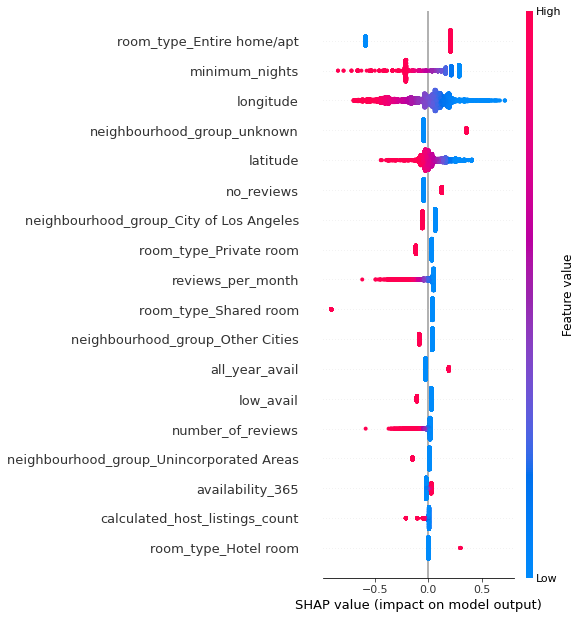

In [29]:
explainer_sh = shap.LinearExplainer(RR, X_train, feature_dependence='independent')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_df.columns)

### 3.3 LASSO Regression

#### 3.3.0 Hyperparameter optimization

The training error for LASSO is somewhat higher than for Ridge. However, the difference is quite small so that LASSO is still useful.

In [30]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha=alpha, max_iter=2000)).mean() for alpha in alphas]

In [31]:
# cv_lasso = pd.Series(cv_lasso, index = alphas) 
# cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-o') 
# plt.xlabel("alpha") 
# plt.ylabel("rmse") 
# plt.xscale('log')

In [32]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = alphas, y= cv_lasso,line = dict(color='crimson', width=2))
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty", font=dict(size=16)
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error", font=dict(size=16)
        )
    )
)

fig.update_layout(height=400, width=600,
                  title='Lasso penalty optimization', 
                  xaxis_type="log", showlegend=False)

fig.show()

#### 3.3.1 Best Lasso Regression Model

In [33]:
best_alpha = alphas[np.argmin(cv_lasso)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
                              'CV error': lasso_CV_best.mean(), 
                              'CV std': lasso_CV_best.std(),
                              'training error': [mean_squared_error(y_train_lasso, y_train)],
                              'test error': [mean_squared_error(y_test_lasso, y_test)],
                              'training_r2_score': [r2_score(y_train, y_train_lasso)],
                              'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

algorithm  CV error   CV std  training error  test error  \
0  LASSO Regression  0.430444  0.00831        0.429828    0.425642   

   training_r2_score  test_r2_score  
0             0.4266       0.428601

#### 3.3.2 Variables selected

In [34]:
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 17 variables and eliminated the other 1 variables


In [35]:
coef

neighbourhood_group_City of Los Angeles    -0.111487
neighbourhood_group_Other Cities           -0.313645
neighbourhood_group_Unincorporated Areas   -0.426035
neighbourhood_group_unknown                -0.021710
room_type_Entire home/apt                  -0.080583
room_type_Hotel room                       -0.002841
room_type_Private room                      0.035979
room_type_Shared room                       0.217604
latitude                                   -0.134923
longitude                                   0.167124
minimum_nights                              0.000000
number_of_reviews                          -0.002569
reviews_per_month                          -0.036748
calculated_host_listings_count              0.517316
availability_365                            0.946281
all_year_avail                              0.423231
low_avail                                  -0.000007
no_reviews                                 -0.794970
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

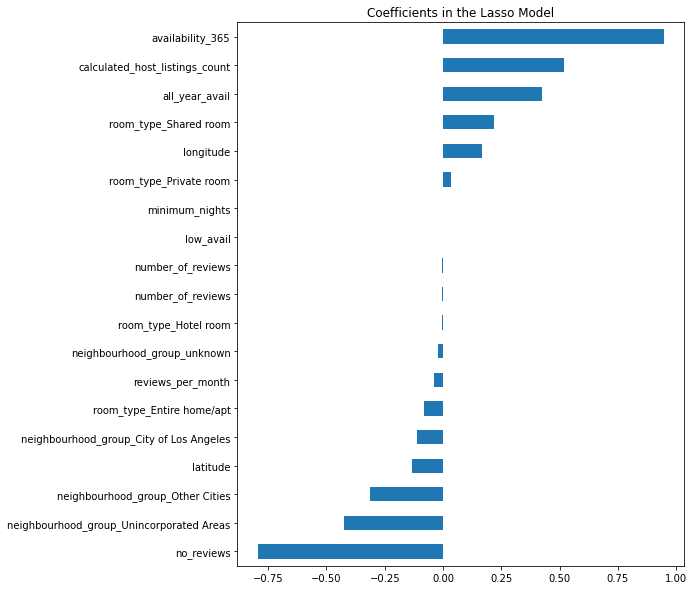

In [36]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-9:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

By inspecting our model coefficients, we find availability_365, calculated_host_listings_count, all_year_avail, room_type_Shared room, longitude all have positive relationship with price. no_reviews, all neighbourhood_group, latitude, room_type_Entire home/apt are negatively associated with the house price.

This is a good way to visualize feature importance, however, numerical variables might have higher absolute coefficients than dummy variables created from a categorical variable.

#### 3.3.3 Interpretation of instance predictions

In [37]:
i=25
exp = explainer.explain_instance(X_test[i], lasso.predict, num_features=5)

Intercept 4.498094089939532
Prediction_local [5.80036038]
Right: 6.046178138159416


In [38]:
exp.show_in_notebook(show_table=True)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


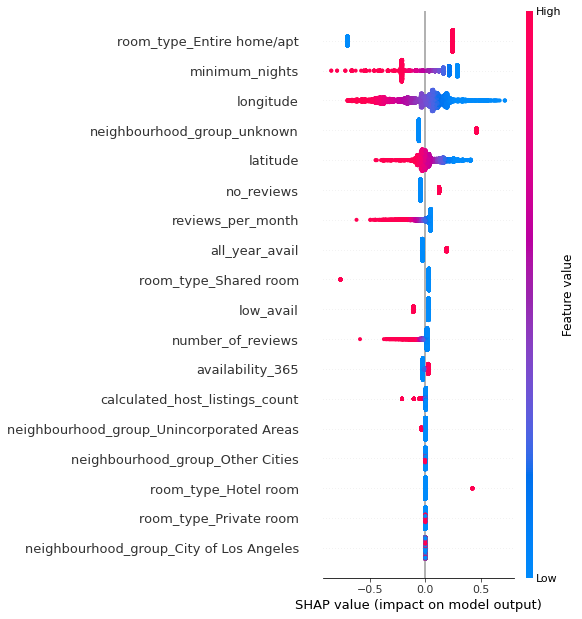

In [39]:
explainer = shap.LinearExplainer(lasso, X_train, feature_dependence='independent')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_df.columns)

### 3.4 Huber Regression

#### 3.4.0 Hyperparameter Tuning

In [40]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

In [41]:
# cv_huber = pd.Series(cv_huber, index = alphas) 
# cv_huber.plot(title = "Huber Regression Cross-Validation", style='-o') 
# plt.xlabel("alpha") 
# plt.ylabel("rmse") 
# plt.xscale('log')

In [42]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas, y= cv_huber, line = dict(color='crimson', width=2)
      )
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty", font=dict(size=16)
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error", font=dict(size=16)
        )
    )
)

fig.update_layout(height=400, width = 600,
                  title = 'Lasso penalty optimization', 
                  xaxis_type="log", showlegend=False)

fig.show()

#### 3.4.1 Best Huber Regression Model

In [43]:
best_alpha = alphas[np.argmin(cv_huber)]
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
                              'CV error': huber_CV_best.mean(), 
                              'CV std': huber_CV_best.std(),
                              'training error': [mean_squared_error(y_train, y_train_huber)],
                              'test error': [mean_squared_error(y_test, y_test_huber)],
                              'training_r2_score': [r2_score(y_train, y_train_huber)],
                              'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

algorithm  CV error    CV std  training error  test error  \
0  Huber Regression  0.436043  0.009184         0.43555     0.43039   

   training_r2_score  test_r2_score  
0           0.418967       0.422228

### 3.5 Ridge with variables selected by LASSO

#### 3.5.0 Hyperparameter Tuning

We rebuild Ridge regression model on the feature subset selected by LASSO. On this dataset this doesn't seem to bring improvement.

In [44]:
lasso_coef = coef[coef!=0]
Xlv = X_df[list(lasso_coef.index)]
Xlv_train, Xlv_test, y_train, y_test = train_test_split(Xlv, y, test_size=0.2, random_state=42)
print('Dimensions of the training features selected by lasso: {}'.format(Xlv_train.shape))
print('Dimensions of the test features selected by lasso: {}'.format(Xlv_test.shape))

Dimensions of the training features selected by lasso: (33277, 17)
Dimensions of the test features selected by lasso: (8320, 17)


In [45]:
for Model in [LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet, RandomForestRegressor, XGBRegressor]:
    if Model == XGBRegressor: 
      cv_res = rmse_lv_cv(XGBRegressor(objective='reg:squarederror'))
    else: 
      cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.45996 +/- 0.010029
Ridge: 0.45996 +/- 0.010029
Lasso: 0.73045 +/- 0.005144


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

HuberRegressor: 0.49509 +/- 0.010377
ElasticNet: 0.73028 +/- 0.005141
RandomForestRegressor: 0.29895 +/- 0.006455
XGBRegressor: 0.37792 +/- 0.008235


#### 3.5.1 Ridge Regression Hyperparameter Optimization



In [46]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha=alpha)).mean() for alpha in alphas1]

In [47]:
alphas2 = [1.4+0.05*i for i in range(1,12)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha=alpha)).mean() for alpha in alphas2]

In [48]:
cv_ridge1 = pd.Series(cv_ridge1, index=alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index=alphas2) 

# fig, axes = plt.subplots(1,2,figsize=(21, 8))
# cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
# axes[0].set_xlabel("alpha") 
# axes[0].set_ylabel("rmse")
# axes[0].set_xscale('log')

# cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
# axes[1].set_xlabel("alpha") 
# axes[1].set_ylabel("rmse")
# axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) 
#RR_best.fit(X_train, y_train) 
#predicted_prices = RR_best.predict(test_data)

#### 3.5.2 Best Ridge Regression Model with Lasso selected features

In [49]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha=best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
                                        'CV error': RR_lassoVars_CV_best.mean(), 
                                        'CV std': RR_lassoVars_CV_best.std(),
                                        'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
                                        'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
                                        'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
                                        'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})

In [122]:
ridge_lassoVars_results

algorithm  CV error    CV std  \
0  Ridge Regression with LASSO variable selection  0.459963  0.010029   

   training error  test error  training_r2_score  test_r2_score  
0        0.459418    0.457773           0.387126       0.385468

### 3.6 Random Forest Regressor

#### 3.6.0 Baseline Random Forest

In [50]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=2022))
rfr_baseline = RandomForestRegressor(random_state=2022)
rfr_baseline.fit(X_train, y_train)
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
                                     'CV error': rfr_CV_baseline.mean(), 
                                     'CV std': rfr_CV_baseline.std(),
                                     'training error': [mean_squared_error(y_train_rfr, y_train)],
                                     'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [51]:
rfr_baseline_results

algorithm  CV error    CV std  training error  \
0  Random Forest Regressor [baseline]  0.277271  0.002643        0.038109   

   test error  
0    0.273719

We see that the training error is nearly an order of magnitude smaller than the test error, and the training error for any of the other algorithms. The baseline model is overfitting massively.

In [52]:
print(rfr_baseline.estimators_)

[DecisionTreeRegressor(max_features='auto', random_state=40194941), DecisionTreeRegressor(max_features='auto', random_state=1642857692), DecisionTreeRegressor(max_features='auto', random_state=2143436973), DecisionTreeRegressor(max_features='auto', random_state=56726128), DecisionTreeRegressor(max_features='auto', random_state=486979249), DecisionTreeRegressor(max_features='auto', random_state=1096548337), DecisionTreeRegressor(max_features='auto', random_state=214636784), DecisionTreeRegressor(max_features='auto', random_state=768078775), DecisionTreeRegressor(max_features='auto', random_state=796319576), DecisionTreeRegressor(max_features='auto', random_state=228722706), DecisionTreeRegressor(max_features='auto', random_state=2091597848), DecisionTreeRegressor(max_features='auto', random_state=339406992), DecisionTreeRegressor(max_features='auto', random_state=1707924789), DecisionTreeRegressor(max_features='auto', random_state=1958492969), DecisionTreeRegressor(max_features='auto', 

#### 3.6.1 Interpretation

ELI5 has built-in support for several ML frameworks and provides a way to explain white-box models (Linear Regression , Decision Trees ) & black-box models (Keras , XGBoost , LightGBM) . It works for both Regression & Classification models. Specifically, it shows us the contribution of each feature in predicting the output.

One pitfall of eli5 is that if scale of input features is different then scale of coefficients will also be different, making direct comparison between coefficient values incorrect.

For the baseline random forest regressor, important features are room type of entire home/apt, latitude, longitude, availability365, calculated host listings count, minimum nights, reviews per month, and number of reviews.

In [53]:
eli5.show_weights(rfr_baseline, feature_names=list(X_df.columns))

#### 3.6.2 Hyperparameter tuning

In [54]:
rf = RandomForestRegressor(random_state=2022)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}


In [55]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [56]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=10, cv=3, verbose=2, random_state=2022, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=2022),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=2022, verbose=2)

In [57]:
pprint(rf_random.best_estimator_.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1788,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}


#### 3.6.3 Best Random Forest Model

In [58]:
best_random = rf_random.best_estimator_
# best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
#                       max_features='auto', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, #min_impurity_split=None,
#                       min_samples_leaf=4, min_samples_split=10,
#                       min_weight_fraction_leaf=0.0, n_estimators=1400,
#                       n_jobs=None, oob_score=False, random_state=2022, verbose=0,
#                       warm_start=False)

rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
                                 'CV error': rfr_CV_best.mean(), 
                                 'CV std': rfr_CV_best.std(),
                                 'training error': [mean_squared_error(y_train, y_train_rfr)],
                                 'test error': [mean_squared_error(y_test, y_test_rfr)],
                                 'training_r2_score': [r2_score(y_train, y_train_rfr)],
                                 'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

algorithm  CV error    CV std  training error  test error  \
0  Random Forest Regressor  0.279738  0.005756        0.052847    0.274737   

   training_r2_score  test_r2_score  
0             0.9295       0.631183

For the best random forest regressor, important features are the same as the important features of the baseline model.

In [59]:
eli5.show_weights(best_random, feature_names=list(X_df.columns))

### 3.7 XGBoost Regressor
#### 3.7.0 Baseline model (default parameters)

In [119]:
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
cv_res = -cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
                                     'CV error': cv_res.mean(), 
                                     'CV std': cv_res.std(),
                                     'training error': [mean_squared_error(y_train_xgb_base, y_train)],
                                     'testing error': [mean_squared_error(y_test_xgb_base, y_test)]})

In [120]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(early_stopping=5, learning_rate=0.05, n_estimators=1000)


algorithm  CV error    CV std  training error  testing error
0  XGBRegressor[baseline]  0.303805  0.005387        0.280196       0.300956

#### 3.7.1 Learning rate optimization

In [62]:
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    # continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

# to run the search, comment out 'continue' in the for loop

[13:11:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [63]:
d

{'CV Error Std': [0.004987683888506342,
  0.00593062710789645,
  0.005333201818773937,
  0.005716771576107529],
 'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.34985837897038924,
  0.30448451865433707,
  0.2968860872396233,
  0.31771149835428614],
 'Training Error': [0.3419458540973798,
  0.28019604113187385,
  0.25471242915940445,
  0.17118472644074567]}

In [64]:
# here are the results I got
d = {'CV Error Std': [0.0051783152910795105,
  0.006019561363371168,
  0.005641253495456337,
  0.00547743003530556],
 'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.34761753812676416,
  0.3029605607163471,
  0.2944061799348508,
  0.31902620709444723],
 'Training Error': [0.33943353254213365,
  0.2779816703364633,
  0.2514938668457073,
  0.16521479420096027]}

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

CV Error Std  Learning Rate  Mean CV Error  Training Error
0      0.005178           0.01       0.347618        0.339434
1      0.006020           0.05       0.302961        0.277982
2      0.005641           0.10       0.294406        0.251494
3      0.005477           0.50       0.319026        0.165215

No handles with labels found to put in legend.


Text(0, 0.5, 'Mean Squared Error')

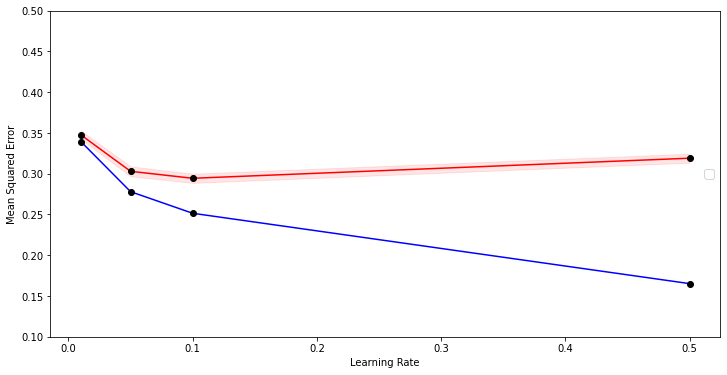

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], color='red')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], 'o', color='black')
ax.fill_between(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'] - xgb_tuning_1['CV Error Std'], xgb_tuning_1['Mean CV Error'] + xgb_tuning_1['CV Error Std'], color='r', alpha=.1)
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], color='blue')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], 'o', color='black')
ax.legend(fontsize=12, loc = 'center right');
ax.set_ylim(0.1, 0.5)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
#ax.set_title('')

#### 3.7.2 max_depth and min_child_weight optimization

In [66]:
d = {'max_depth':[],
     'min_child_weight': [],
     'Mean CV Error': [],
     'CV Error Std': [],
     'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(n_folds, shuffle=True, random_state = 2022).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        # continue
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

print(d)

# to run the search, comment out 'continue' in the for loop

[13:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [67]:
d

{'CV Error Std': [0.0051043795964878765,
  0.0048229359387392265,
  0.004834956395303727,
  0.0036427647508705105,
  0.0028681845047218383,
  0.003775567435528462,
  0.0054429362617368126,
  0.003738318261279588,
  0.004750464883611166,
  0.0042770129476657655,
  0.004879933682802371,
  0.00533096578795299],
 'Mean CV Error': [0.2941884197238398,
  0.293584224407509,
  0.29376938903898364,
  0.2795179064409153,
  0.27936262671382117,
  0.2793058442135833,
  0.2755796407557519,
  0.2763746793967467,
  0.2759331757688906,
  0.27484196187054877,
  0.2757617883363889,
  0.2758634724365588],
 'Training Error': [0.25471242915940445,
  0.25462031294369253,
  0.254796831093861,
  0.16551312708199697,
  0.16663560313453826,
  0.17119826043209474,
  0.08027275804226504,
  0.08929959544451112,
  0.09231684892785644,
  0.02750715590972315,
  0.03246874913390069,
  0.04331153000047406],
 'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5]}

In [68]:
# here are the results I got
d = {'CV Error Std': [0.0051043795964878765,
  0.0048229359387392265,
  0.004834956395303727,
  0.0036427647508705105,
  0.0028681845047218383,
  0.003775567435528462,
  0.0054429362617368126,
  0.003738318261279588,
  0.004750464883611166,
  0.0042770129476657655,
  0.004879933682802371,
  0.00533096578795299],
 'Mean CV Error': [0.2941884197238398,
  0.293584224407509,
  0.29376938903898364,
  0.2795179064409153,
  0.27936262671382117,
  0.2793058442135833,
  0.2755796407557519,
  0.2763746793967467,
  0.2759331757688906,
  0.27484196187054877,
  0.2757617883363889,
  0.2758634724365588],
 'Training Error': [0.25471242915940445,
  0.25462031294369253,
  0.254796831093861,
  0.16551312708199697,
  0.16663560313453826,
  0.17119826043209474,
  0.08027275804226504,
  0.08929959544451112,
  0.09231684892785644,
  0.02750715590972315,
  0.03246874913390069,
  0.04331153000047406],
 'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5]}
        
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

CV Error Std  Mean CV Error  Training Error  max_depth  min_child_weight
0       0.004898       0.291652        0.251494          3                 1
1       0.005067       0.291609        0.251571          3                 3
2       0.005121       0.291471        0.251876          3                 5
3       0.003457       0.277628        0.160618          5                 1
4       0.003799       0.276671        0.163561          5                 3
5       0.003834       0.277438        0.163880          5                 5
6       0.003717       0.274798        0.074856          7                 1
7       0.004370       0.274261        0.080823          7                 3
8       0.005120       0.273468        0.084839          7                 5
9       0.005112       0.273662        0.021401          9                 1
10      0.005113       0.272987        0.026066          9                 3
11      0.003557       0.272552        0.036083          9                 5

(0.27, 0.3)

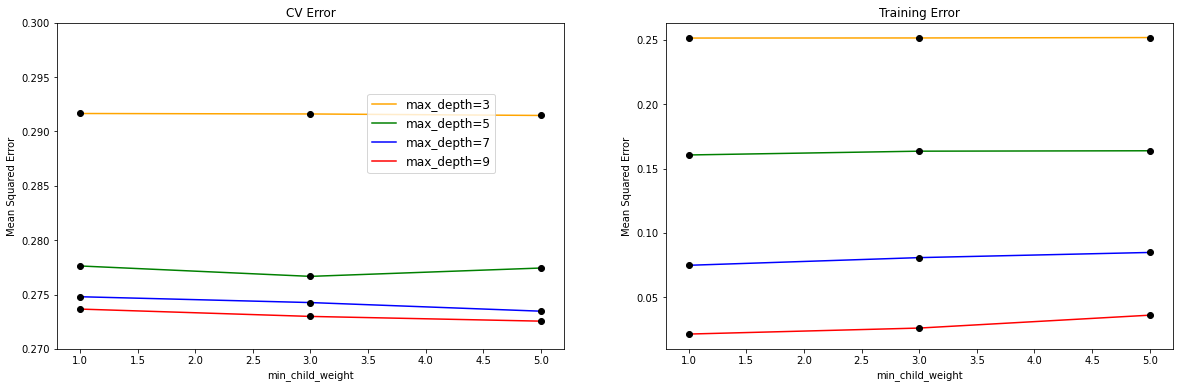

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

colors = ['orange','green','blue','red']

for i, md in enumerate(params2['max_depth']):
    color = colors[i]
    xgb_tuning_3 = xgb_tuning_2[xgb_tuning_2['max_depth']==md]
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], color=color, label= 'max_depth='+str(md))
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], 'o', color='black', label='_nolegend_')
    #ax.fill_between(xgb_tuning_3['Max_depth'], xgb_tuning_3['Mean CV Error'] - xgb_tuning_3['CV Error Std'], 
                    #xgb_tuning_3['Mean CV Error'] + xgb_tuning_3['CV Error Std'], color='r', alpha=.1, label='_nolegend_')
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], color=color, label='max_depth='+str(md))
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], 'o', color='black', label='_nolegend_')

for ax in axes:
    ax.set_xlabel('min_child_weight')
    ax.set_ylabel('Mean Squared Error')
    
axes[0].set_title('CV Error')
axes[1].set_title('Training Error')

axes[0].legend(fontsize=12, bbox_to_anchor=(0.6, .52, .7, .602), loc=3,);
axes[0].set_ylim([0.27, 0.30])

In [103]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 9
min_child_weight: 5


#### 3.7.3 Best XGBRegressor

In [71]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, 
                           early_stopping=5, max_depth=9, min_child_weight=5)
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
                                 'CV error': xbgreg_CV_best.mean(), 
                                 'CV std': xbgreg_CV_best.std(),
                                 'training error': [mean_squared_error(y_train, y_train_xgbreg)],
                                 'test error': [mean_squared_error(y_test, y_test_xgbreg)],
                                 'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
                                 'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[13:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


algorithm  CV error    CV std  training error  test error  \
0  XGBRegressor  0.275863  0.005331        0.043312    0.270926   

   training_r2_score  test_r2_score  
0           0.942221       0.636298

ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions

For the best XGB regressor, important features are room type of entire home/apt, room type of shared room, neighbourhood group unknown. 

In [72]:
eli5.show_weights(xbgreg_best, feature_names=list(X_df.columns))

In [73]:
explainer = shap.TreeExplainer(xbgreg_best)

In [88]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = list(X_df.columns)
# X_train_df

In [89]:
X_sampled = X_train_df.sample(100, random_state=2022)

In [90]:
shap_values = explainer(X_sampled)

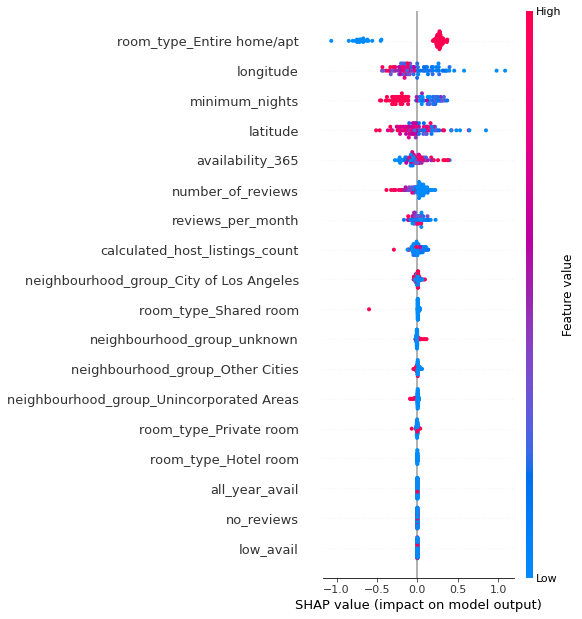

In [92]:
shap.summary_plot(shap_values, X_sampled)

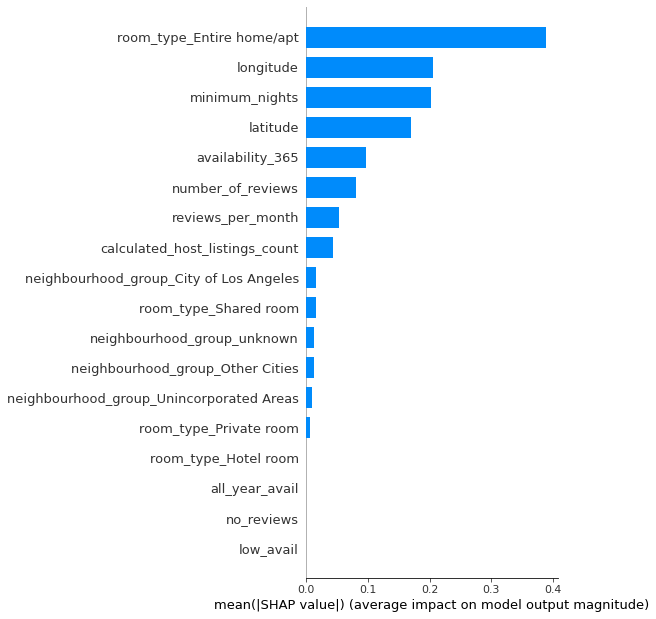

In [93]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

The waterfall plot shows for a specific house, how the values of features drive the prediction of the price. 

As shown in the plot below, we know that minimum nights, entire home/apt room type, latitude, number of review per month, longitude, number of reviews, calculated host listings count, and availability365 are important features. Among them, entire home/apt room type and longitude lead to higher price, while other features lead to lower price. A combined effect of those features helps the model to make prediction of price.

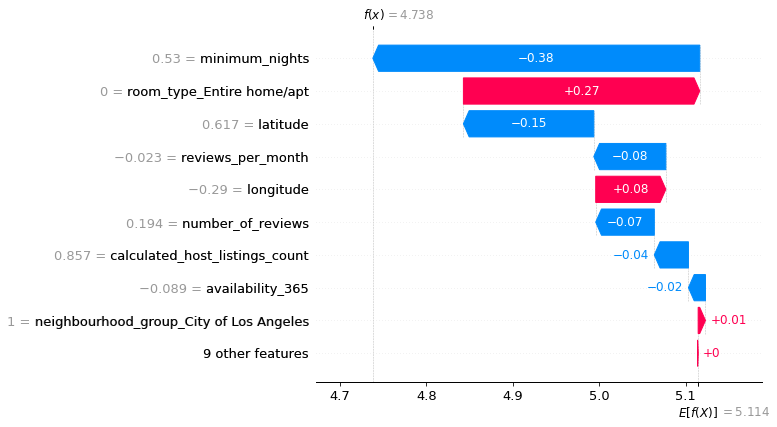

In [108]:
shap.plots.waterfall(shap_values[0])

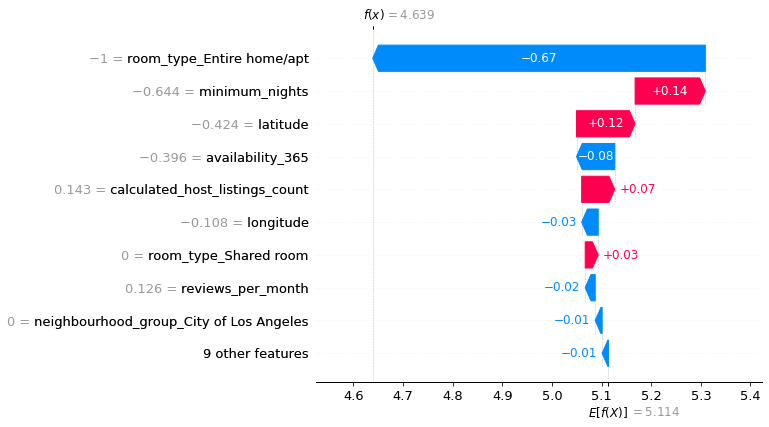

In [114]:
shap.plots.waterfall(shap_values[1])

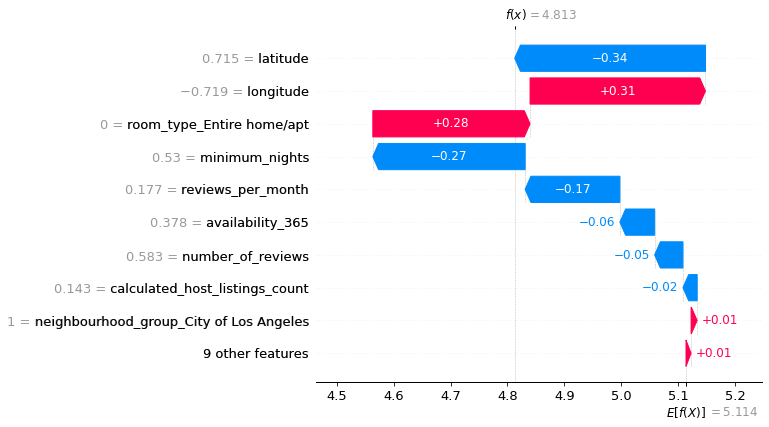

In [111]:
shap.plots.waterfall(shap_values[2])

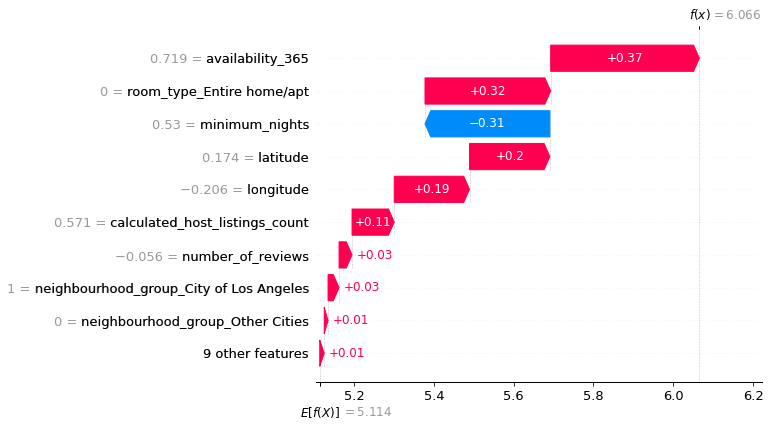

In [112]:
shap.plots.waterfall(shap_values[3])

In [98]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])
# shap.force_plot(explainer.expected_value, shap_values, X_sampled)

In [100]:
import pickle
with open('./drive/MyDrive/Colab Notebooks/kaggle/airbnb/model', 'wb') as file:
  pickle.dump(xbgreg_best, file)

## 4. Summary of Model Performance

In [101]:
pd.concat([ridge_results, lasso_results, ridge_lassoVars_results, huber_results, rfr_best_results, xgb_best_results], axis=0, ignore_index=True)

algorithm  CV error    CV std  \
0                                Ridge Regression  0.430442  0.008310   
1                                LASSO Regression  0.430444  0.008310   
2  Ridge Regression with LASSO variable selection  0.459963  0.010029   
3                                Huber Regression  0.436043  0.009184   
4                         Random Forest Regressor  0.279738  0.005756   
5                                    XGBRegressor  0.275863  0.005331   

   training error  test error  training_r2_score  test_r2_score  
0        0.429824    0.000000           0.426606       0.428662  
1        0.429828    0.425642           0.426600       0.428601  
2        0.459418    0.457773           0.387126       0.385468  
3        0.435550    0.430390           0.418967       0.422228  
4        0.052847    0.274737           0.929500       0.631183  
5        0.043312    0.270926           0.942221       0.636298

## 5. Model interpretability Reference

1. Kevin Lemagnen's 2018 NYC PyData talk: [Open the Black Box: an Introduction to Model Interpretability with LIME and SHAP](https://www.youtube.com/watch?v=C80SQe16Rao)
2. Lime Regression example can be found in [this notebook](https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html)
3. Explanation of LIME algorithm and LIME results in [this blog](https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5)
4. [The original SHAP paper](https://arxiv.org/abs/1705.07874) is quite readable